# Layer 4 project. Patch-seq analysis

In [1]:
# Prepare

%matplotlib notebook

import numpy as np
import pylab as plt
import seaborn as sns; sns.set()
import pandas as pd
import matplotlib
import pickle
import scipy
import time
from collections import namedtuple
from scipy import sparse

# import t-SNE from https://github.com/KlugerLab/FIt-SNE
import sys; sys.path.append('/home/localadmin/github/FIt-SNE')
from fast_tsne import fast_tsne

# import my feature selection function 
# This file is from https://github.com/berenslab/rna-seq-tsne but a version
# used for this project is included in this repository
import rnaseqTools

# import my reduced-rank regression function 
# This file is from https://github.com/berenslab/patch-seq-rrr but a version
# used for this project is included in this repository
import sparseRRR

def sns_styleset():
    sns.set_context('paper')
    sns.set_style('ticks')
    matplotlib.rcParams['axes.linewidth']    = .75
    matplotlib.rcParams['xtick.major.width'] = .75
    matplotlib.rcParams['ytick.major.width'] = .75
    matplotlib.rcParams['xtick.major.size'] = 3
    matplotlib.rcParams['ytick.major.size'] = 3
    matplotlib.rcParams['font.size']       = 7
    matplotlib.rcParams['axes.titlesize']  = 7
    matplotlib.rcParams['axes.labelsize']  = 7
    matplotlib.rcParams['legend.fontsize'] = 7
    matplotlib.rcParams['xtick.labelsize'] = 7
    matplotlib.rcParams['ytick.labelsize'] = 7
    
sns_styleset()

## Load the data

### Our data

Will fill in later.

### Tasic 2018 data
Download the data from here: http://celltypes.brain-map.org/rnaseq and unpack. Direct links:
 * VISp: http://celltypes.brain-map.org/api/v2/well_known_file_download/694413985
 * ALM: http://celltypes.brain-map.org/api/v2/well_known_file_download/694413179

To get the information about cluster colors and labels (`sample_heatmap_plot_data.csv`), open the interactive data browser http://celltypes.brain-map.org/rnaseq/mouse, go to "Sample Heatmaps", click "Build Plot!" and then "Download data as CSV".

In [7]:
%%time

# Load the Allen institute data. This takes a bit of time but saves the result 
# to a .pickle file that can be quickly loaded afterwards

# This function is needed because using Pandas to load these files in one go 
# can eat up a lot of RAM. So we are doing it in chunks, and converting each
# chunk to the sparse matrix format on the fly.
def sparseload(filename):
    with open(filename) as file:
        genes = []
        sparseblocks = []
        for i,chunk in enumerate(pd.read_csv(filename, chunksize=1000, index_col=0)):
            print('.', end='', flush=True)
            if i==0:
                cells = np.array(chunk.columns)
            genes.extend(list(chunk.index))
            sparseblock = sparse.csr_matrix(chunk.values.astype(float))
            sparseblocks.append([sparseblock])
        counts = sparse.bmat(sparseblocks)
        print(' done')
    return (counts.T, np.array(genes), cells)

filename = '../../data/tasic-nature/mouse_VISp_2018-06-14_exon-matrix.csv'
counts1, genes, cells1 = sparseload(filename)

filename = '../../data/tasic-nature/mouse_ALM_2018-06-14_exon-matrix.csv'
counts2, genes2, cells2 = sparseload(filename)

counts = sparse.vstack((counts1, counts2), format='csc')
counts1, counts2 = [], []
cells = np.concatenate((cells1, cells2))
assert(np.all(genes==genes2))

genesDF = pd.read_csv('../../data/tasic-nature/mouse_VISp_2018-06-14_genes-rows.csv')
ids     = genesDF['gene_entrez_id'].tolist()
symbols = genesDF['gene_symbol'].tolist()
id2symbol = dict(zip(ids, symbols))
genes = np.array([id2symbol[g] for g in genes])

clusterInfo = pd.read_csv('../../data/tasic-nature/sample_heatmap_plot_data.csv')
goodCells  = clusterInfo['sample_name'].values
ids        = clusterInfo['cluster_id'].values
labels     = clusterInfo['cluster_label'].values
colors     = clusterInfo['cluster_color'].values

clusterNames  = np.array([labels[ids==i+1][0] for i in range(np.max(ids))])
clusterColors = np.array([colors[ids==i+1][0] for i in range(np.max(ids))])
clusters   = np.copy(ids) - 1

ind = np.array([np.where(cells==c)[0][0] for c in goodCells])
counts = counts[ind, :]

areas = (ind < cells1.size).astype(int)

tasic2018 = {'counts': counts, 'genes': genes, 'clusters': clusters, 'areas': areas, 
             'clusterColors': clusterColors, 'clusterNames': clusterNames}

pickle.dump(tasic2018, open('../../data/allen-visp-alm/tasic2018.pickle', 'wb'))

.............................................. done
.............................................. done
CPU times: user 3min 55s, sys: 10.6 s, total: 4min 6s
Wall time: 4min 8s


In [42]:
# The above cell needs to be run only once. Then one can load the data 
# from the .pickle file which is much faster

tasic2018 = pickle.load(open('../../data/tasic-nature/tasic2018.pickle', 'rb'))

print('Number of cells:', tasic2018['counts'].shape[0])
print('Number of cells from ALM:', np.sum(tasic2018['areas']==0))
print('Number of cells from VISp:', np.sum(tasic2018['areas']==1))
print('Number of clusters:', np.unique(tasic2018['clusters']).size)
print('Number of genes:', tasic2018['counts'].shape[1])
print('Fraction of zeros in the data matrix: {:.2f}'.format(
    tasic2018['counts'].size/np.prod(tasic2018['counts'].shape)))

Number of cells: 23822
Number of cells from ALM: 9573
Number of cells from VISp: 14249
Number of clusters: 133
Number of genes: 45768
Fraction of zeros in the data matrix: 0.20


In [7]:
%%time

# Highly variable genes and t-SNE of the whole Tasic data set.
# Also running this once and pickling the result.

importantGenesTasic = rnaseqTools.geneSelection(tasic2018['counts'], n=3000, threshold=32, plot=False)

librarySizes = np.sum(tasic2018['counts'], axis=1)
X = np.log2(tasic2018['counts'][:, importantGenesTasic] / librarySizes * 1e+6 + 1)  
X = np.array(X)
X = X - X.mean(axis=0)
U,s,V = np.linalg.svd(X, full_matrices=False)
U[:,np.sum(V,axis=1)<0] *= -1
X = np.dot(U, np.diag(s))
X = X[:, np.argsort(s)[::-1]][:,:50]

PCAinit = X[:,:2]/np.std(X[:,0])*.0001
Z_tasic = fast_tsne(X, perplexity_list = [30, int(X.shape[0]/100)], 
                    initialization = PCAinit, learning_rate = X.shape[0]/12)

pickle.dump([Z_tasic, importantGenesTasic], open('tasic_tsne.pickle', 'wb'))

Chosen offset: 6.56
CPU times: user 1min 35s, sys: 6.92 s, total: 1min 42s
Wall time: 2min 30s


In [43]:
Z_tasic, importantGenesTasic = pickle.load(open('tasic_tsne.pickle', 'rb'))

In [4]:
# Load L4 data

data = pd.read_csv("../../../BICCN patch-seq data/L4/rnaseq/counts.csv", sep='\t')
counts = data.values[:,1:].transpose().astype(float)
genes = data.values[:,0]
cells = np.array(data.columns[1:])

print('Number of cells: {}\nNumber of genes: {}'.format(counts.shape[0], counts.shape[1]))

meta = pd.read_excel('../../../BICCN patch-seq data/L4/Layer 4 cells.xlsx', index_col=0)
d = [d[6:10]+d[:2]+d[3:5] for d in meta.values[1:,1] if d is not np.nan]
s = [s[7:].strip() if 'sample ' in s else s[6:].strip() for s in meta.values[1:,2] if s is not np.nan]
names = [d[i]+'_sample_'+s[i] for i in range(len(d))]
regions = [m for m in meta.values[1:,3] if m=='V1' or m=='S1']
layers = [m for m in meta.values[1:,4] if ~np.isnan(m)]
names2regions = dict(zip(names,regions))
names2layers = dict(zip(names,layers))

for h in cells:
    if '_'.join(h.split('_')[:3]) not in names2regions:
        print('NO META INFO: ' + h)
        
regions = np.array([names2regions['_'.join(c.split('_')[:3])] for c in cells])
layers  = np.array([names2layers['_'.join(c.split('_')[:3])] for c in cells])

ephysData = pd.read_csv('../ephys/data/patch-seq-ephys-features.csv')
ephysNames = np.array(ephysData.columns[1:-2])
ephysCells = np.array([s.split('sample')[0]+'_sample_'+s.split('sample')[1] for s in ephysData.values[:,0]])
keep = ephysData['Good quality']
ai0 = ephysData['AI']==0
ephysData = ephysData.values[:, 1:-2].astype('float')
ephysData[~keep,:] = np.nan
ephysData[keep, ephysNames=='Latency (ms)'] = np.log(ephysData[keep, ephysNames=='Latency (ms)'])
ephysData[keep & ~ai0, ephysNames=='AI'] = np.log(ephysData[keep & ~ai0, ephysNames=='AI']/100)
ephysData[ai0, ephysNames=='AI'] = np.nan
names2ephys = dict(zip(ephysCells, ephysData))
ephys = np.array([names2ephys['_'.join(c.split('_')[:3])] if '_'.join(c.split('_')[:3]) in names2ephys
          else np.ones(ephysNames.size)*np.nan for c in cells]).astype(float)

l4 = {'counts': counts, 'cells': cells, 'genes': genes, 
      'regions': regions, 'layers': layers, 'ephys': ephys,
      'ephysNames': ephysNames}

print('')
print(ephysNames)
print(ephysNames.size)

Number of cells: 118
Number of genes: 26514

['ADP (mV)' 'AHP (mV)' 'AI' 'AP amplitude (mV)' 'AP threshold (mV)'
 'AP width (ms)' 'Max number of spikes' 'Input R (MOhm)' 'Vm (mV)'
 'Latency (ms)' 'Rheobase (pA)' 'Sag ratio' 'Tau (ms)']
13


## Quality control and summary statistics

In [44]:
# Quality control

_, Cmeans = rnaseqTools.map_to_clusters(tasic2018['counts'][:, importantGenesTasic],
                tasic2018['genes'][importantGenesTasic],
                l4['counts'], l4['genes'], 
                tasic2018['clusters'], returnCmeans=True)

pos_reference = rnaseqTools.map_to_tsne(tasic2018['counts'][:, importantGenesTasic],
                              tasic2018['genes'][importantGenesTasic],
                              l4['counts'], l4['genes'], Z_tasic)

nn = np.where(tasic2018['clusterNames']=='Astro Aqp4')[0][0]
lowq = np.sum(l4['counts']>0, axis=1) < 1500
good = ~lowq

ind1 = np.where(tasic2018['clusterNames']=='L2/3 IT VISp Rrad')[0][0]
ind2 = np.where(tasic2018['clusterNames']=='L6b Hsd17b2')[0][0] + 1
excit = np.isin(np.argmax(Cmeans, axis=1), np.arange(ind1, ind2))

ind1 = np.where(tasic2018['clusterNames']=='Pvalb Gabrg1')[0][0]
ind2 = np.where(tasic2018['clusterNames']=='Pvalb Vipr2')[0][0] + 1
pvalb = np.isin(np.argmax(Cmeans, axis=1), np.arange(ind1, ind2))

print('')
print('{} cell(s) with < 1500 detected genes'.format(np.sum(lowq)))
print('{} cell(s) mapped to excitatory clusters'.format(np.sum(excit)))
print('{} cell(s) mapped to PV clusters'.format(np.sum(pvalb)))
print('\n{} remaining cell(s) had bad/missing ephys'.format(
    np.sum(good & ~excit & ~pvalb & np.isnan(ephys[:,0]))))
print('\n{} further cell(s) had AI=0'.format(
    np.sum(good & ~excit & ~pvalb & ~np.isnan(ephys[:,0]) & np.isnan(ephys[:,ephysNames=='AI'][:,0]))))

Using a common set of 2686 genes.
Using a common set of 2686 genes.

4 cell(s) with < 1500 detected genes
1 cell(s) mapped to excitatory clusters
3 cell(s) mapped to PV clusters

8 remaining cell(s) had bad/missing ephys

0 further cell(s) had AI=0


In [23]:
_,_ = rnaseqTools.map_to_clusters(
    tasic2018['counts'][:, importantGenesTasic],
    tasic2018['genes'][importantGenesTasic],
    l4['counts'], 
    l4['genes'], 
    tasic2018['clusters'], bootstrap=True, seed=42, 
    verbose=True, referenceClusterNames=tasic2018['clusterNames'], cellNames=l4['cells'])

Using a common set of 2686 genes.
Bootstrapping.................................................................................................... done
20180604_sample_1_L4_S97: Sst Tac1 Htr1d (91.0%), Sst Tac1 Tacr3 (9.0%)
20180604_sample_2_L4_S98: Sst Calb2 Pdlim5 (100.0%)
20180604_sample_3_L4_S99: Sst Hpse Cbln4 (97.0%)
20180605_sample_1_L4_S100: Sst Hpse Cbln4 (100.0%)
20180605_sample_2_L4_S101: Sst Calb2 Pdlim5 (91.0%), Sst Hpse Cbln4 (9.0%)
20180605_sample_3_L4_S102: Sst Tac1 Tacr3 (36.0%), Sst Calb2 Necab1 (35.0%), Sst Calb2 Pdlim5 (25.0%)
20180605_sample_4_L4_S103: Sst Hpse Cbln4 (100.0%)
20180605_sample_5_L4_S104: Sst Calb2 Pdlim5 (100.0%)
20180605_sample_12_L4_S109: Sst Hpse Cbln4 (69.0%), Sst Hpse Sema3c (15.0%), Sst Calb2 Pdlim5 (7.0%), Sst Tac1 Tacr3 (5.0%)
20180605_sample_6_L4_S105: Sst Calb2 Pdlim5 (100.0%)
20180605_sample_7_L4_S106: Sst Calb2 Pdlim5 (100.0%)
20180605_sample_11_L4_S107: Sst Hpse Cbln4 (61.0%), Sst Calb2 Pdlim5 (36.0%)
20180605_sample_13_L4_S110: Sst Cal

<IPython.core.display.Javascript object>


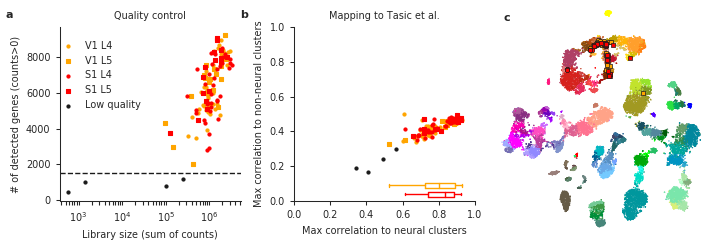

In [45]:
sns_styleset()
plt.figure(figsize=(7.2, 2.5))
s=5

plt.subplot(131)
plt.gca().set_xscale('log')
x = np.sum(l4['counts'], axis=1)
y = np.sum(l4['counts']>0, axis=1)
cells = good & (l4['regions']=='V1') & (l4['layers']==4)
plt.scatter(x[cells], y[cells], s=s, color='orange')
cells = good & (l4['regions']=='V1') & (l4['layers']==5)
plt.scatter(x[cells], y[cells], s=s, color='orange', marker='s')
cells = good & (l4['regions']=='S1') & (l4['layers']==4)
plt.scatter(x[cells], y[cells], s=s, color='#ff0000')
cells = good & (l4['regions']=='S1') & (l4['layers']==5)
plt.scatter(x[cells], y[cells], s=s, color='#ff0000', marker='s')
plt.scatter(x[lowq], y[lowq], s=s, color='k')
plt.legend(['V1 L4', 'V1 L5', 'S1 L4', 'S1 L5', 'Low quality'], frameon=False, loc=[-.03,.5])
span = plt.xlim()
plt.plot(span, [1500, 1500], 'k--', linewidth=1)
plt.xlim(span)
plt.xlabel('Library size (sum of counts)')
plt.ylabel('# of detected genes (counts>0)')
plt.title('Quality control')
sns.despine()
plt.tight_layout()

plt.subplot(132)
x = np.amax(Cmeans[:,:nn], axis=1)
y = np.amax(Cmeans[:,nn:], axis=1)
# plt.scatter(x[cont], y[cont], s=s, color='b')
plt.scatter(x[lowq], y[lowq], s=s, color='k')
cells = good & (l4['regions']=='V1') & (l4['layers']==4)
plt.scatter(x[cells], y[cells], s=s, color='orange')
cells = good & (l4['regions']=='V1') & (l4['layers']==5)
plt.scatter(x[cells], y[cells], s=s, color='orange', marker='s')
cells = good & (l4['regions']=='S1') & (l4['layers']==4)
plt.scatter(x[cells], y[cells], s=s, color='#ff0000')
cells = good & (l4['regions']=='S1') & (l4['layers']==5)
plt.scatter(x[cells], y[cells], s=s, color='#ff0000', marker='s')
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('Max correlation to neural clusters')
plt.ylabel('Max correlation to non-neural clusters')
# plt.plot([0,1], [.4,.4], 'k--', linewidth=1)
# plt.plot([.4,.4], [0,.4], 'k--', linewidth=1)
# plt.text(.2,.1, 'Bad')
plt.title('Mapping to Tasic et al.')

cells = good & (l4['regions']=='V1')
bp = plt.boxplot(x[cells], vert=False, positions=[.09], widths=[.03])
for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
    plt.setp(bp[element], color='orange')
cells = good & (l4['regions']=='S1')
bp = plt.boxplot(x[cells], vert=False, positions=[.04], widths=[.03])
for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
    plt.setp(bp[element], color='#ff0000')
plt.ylim([0,1])
plt.yticks(np.arange(0,1.001,.2))
plt.gca().set_yticklabels([0.0,.2,.4,.6,.8,1.0])
sns.despine()
plt.tight_layout()

ax3 = plt.axes([.67, .05, .33, .95], aspect='equal')
plt.scatter(Z_tasic[:,0], Z_tasic[:,1], s=1, edgecolor='none', rasterized=True,
            c=tasic2018['clusterColors'][tasic2018['clusters']])
plt.xticks([])
plt.yticks([])

selection = good

ii = (l4['regions'][selection]=='V1') & (l4['layers'][selection]==4) 
a = plt.scatter(pos_reference[selection,:][ii,0], pos_reference[selection,:][ii,1], s=s*2, 
                color='orange', edgecolors='k', linewidth=.5)
ii = (l4['regions'][selection]=='V1') & (l4['layers'][selection]==5) 
b = plt.scatter(pos_reference[selection,:][ii,0], pos_reference[selection,:][ii,1], s=s*2, 
                color='orange', edgecolors='k', linewidth=.5, marker='s')

ii = (l4['regions'][selection]=='S1') & (l4['layers'][selection]==4) 
c = plt.scatter(pos_reference[selection,:][ii,0], pos_reference[selection,:][ii,1], s=s*2, 
                color='#ff0000', edgecolors='k', linewidth=.5)
ii = (l4['regions'][selection]=='S1') & (l4['layers'][selection]==5) 
d = plt.scatter(pos_reference[selection,:][ii,0], pos_reference[selection,:][ii,1], s=s*2, 
                color='#ff0000', edgecolors='k', linewidth=.5, marker='s')

sns.despine(ax=ax3, left=True, bottom=True)

plt.text(-.3, 1.05,  'a', transform = plt.gcf().get_axes()[0].transAxes, fontsize=8, fontweight='bold')
plt.text(-.3, 1.05,  'b', transform = plt.gcf().get_axes()[1].transAxes, fontsize=8, fontweight='bold')
plt.text(0.05, .91,  'c', transform = plt.gcf().get_axes()[2].transAxes, fontsize=8, fontweight='bold')

plt.savefig('../figures/patch-seq-qc.png', dpi=200)
plt.savefig('../figures/patch-seq-qc.pdf')

In [46]:
print('Low quality RNA:')
for c in np.where(lowq)[0]:
    print('  ' + l4['cells'][c] + '\t (L' + str(int(l4['layers'][c])) + ', ' + l4['regions'][c] + ')')
    
print('\nMaps to Pvalb:')
for c in np.where(pvalb)[0]:
    print('  ' + l4['cells'][c] + '\t (L' + str(int(l4['layers'][c])) + ', ' + l4['regions'][c] + ')')
    
print('\nMaps to excitatory:')
for c in np.where(excit)[0]:
    print('  ' + l4['cells'][c] + '\t (L' + str(int(l4['layers'][c])) + ', ' + l4['regions'][c] + ')')
    
print('\nNo ephys or bad quality ephys:')
for c in np.where(~lowq & ~pvalb & ~excit & np.isnan(l4['ephys'][:,0]))[0]:
    print('  ' + l4['cells'][c] + '\t (L' + str(int(l4['layers'][c])) + ', ' + l4['regions'][c] + ')')
    
# print('\nAI=0:')
# for c in np.where(~lowq & ~pvalb & ~excit & ~np.isnan(l4['ephys'][:,0]) & 
#                   np.isnan(ephys[:,ephysNames=='AI'][:,0]))[0]:
#     print('  ' + l4['cells'][c] + '\t (L' + str(int(l4['layers'][c])) + ', ' + l4['regions'][c] + ')')

Low quality RNA:
  20180605_sample_12_L4_S109	 (L4, V1)
  20180626_sample_11_L4_S129	 (L4, V1)
  20180703_sample_6_L4_S157	 (L5, V1)
  20180919_sample_21_L4_S136	 (L4, S1)

Maps to Pvalb:
  20180605_sample_17_L4_S114	 (L4, S1)
  20180626_sample_7_L4_S125	 (L4, S1)
  20180627_sample_1_L4_S137	 (L4, S1)

Maps to excitatory:
  20180703_sample_4_L4_S154	 (L5, V1)

No ephys or bad quality ephys:
  20180604_sample_3_L4_S99	 (L4, V1)
  20180605_sample_1_L4_S100	 (L4, V1)
  20180605_sample_11_L4_S107	 (L4, V1)
  20180703_sample_2_L4_S152	 (L4, V1)
  20180919_sample_1_L4_S102	 (L4, V1)
  20180920_sample_6_L4_S151	 (L4, V1)
  20180920_sample_7_L4_S153	 (L4, V1)
  20180920_sample_12_L4_S160	 (L4, V1)


In [47]:
# Summary statistics

selection = good & ~pvalb & ~excit
print('Number of cells after transcriptomic QC:', np.sum(selection))
selection = good & ~pvalb & ~excit & (l4['layers']==4) & (l4['regions']=='V1')
print('In V1 L4:', np.sum(selection))
selection = good & ~pvalb & ~excit & (l4['layers']==4) & (l4['regions']=='S1')
print('In S1 L4:', np.sum(selection))
selection = good & ~pvalb & ~excit & (l4['layers']==5) & (l4['regions']=='V1')
print('In V1 L5:', np.sum(selection))
selection = good & ~pvalb & ~excit & (l4['layers']==5) & (l4['regions']=='S1')
print('In S1 L5:', np.sum(selection))

print('')
selection = good & ~pvalb & ~excit
print('Mean # of genes detected:\t{:.0f}'.format(np.mean(np.sum(l4['counts'][selection,:]>0, axis=1))))
print('Std of # of genes detected:\t{:.0f}'.format(np.std(np.sum(l4['counts'][selection,:]>0, axis=1))))
print('Mean log10 library size:\t{:.1f}'.format(np.mean(np.log10(np.sum(l4['counts'][selection,:], axis=1)))))
print('Std of log10 library size:\t{:.1f}'.format(np.std(np.log10(np.sum(l4['counts'][selection,:], axis=1)))))
print('Median library size:    \t{:.0f}'.format(np.median(np.sum(l4['counts'][selection,:], axis=1))))

Number of cells after transcriptomic QC: 110
In V1 L4: 42
In S1 L4: 35
In V1 L5: 17
In S1 L5: 16

Mean # of genes detected:	6396
Std of # of genes detected:	1623
Mean log10 library size:	6.0
Std of log10 library size:	0.3
Median library size:    	1096478


## Mapping to the Sst clusters of Tasic et al.

Number of Sst clusters: 21
Number of cells in the Sst clusters: 2880

Number of Sst clusters without Chodl: 20
Number of cells in the Sst clusters without Chodl: 2701

Chosen offset: 6.39


<IPython.core.display.Javascript object>


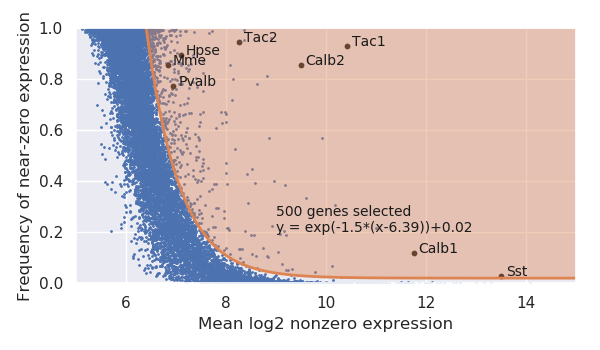

In [48]:
sstcl = np.array([c[:3]=='Sst' for c in tasic2018['clusterNames']])
sst = np.isin(tasic2018['clusters'], np.where(sstcl)[0])

print('Number of Sst clusters:', np.sum(sstcl))
print('Number of cells in the Sst clusters:', np.sum(sst))
print('')

sstcl = np.array([c[:3]=='Sst' and c[4:]!='Chodl' for c in tasic2018['clusterNames']])
sst = np.isin(tasic2018['clusters'], np.where(sstcl)[0])

print('Number of Sst clusters without Chodl:', np.sum(sstcl))
print('Number of cells in the Sst clusters without Chodl:', np.sum(sst))
print('')

sns.set()
sstgenes = rnaseqTools.geneSelection(tasic2018['counts'][sst,:], n=500, threshold=32,
                                     markers=['Sst', 'Pvalb', 'Hpse', 'Calb2', 'Calb1', 'Mme', 'Tac1', 'Tac2'],
                                     genes=tasic2018['genes'])

In [49]:
# Do t-SNE of SST only

librarySizes = np.sum(tasic2018['counts'], axis=1)
X = np.log2(tasic2018['counts'][:, sstgenes][sst,:] / librarySizes[sst] * 1e+6 + 1)  
X = np.array(X)
X = X - X.mean(axis=0)
U,s,V = np.linalg.svd(X, full_matrices=False)
U[:,np.sum(V,axis=1)<0] *= -1
X = np.dot(U, np.diag(s))
X = X[:, np.argsort(s)[::-1]][:,:50]
PCAinit = X[:,:2]/np.std(X[:,0])*.0001

Zsstonly = fast_tsne(X, perplexity = 50, initialization = PCAinit)

<IPython.core.display.Javascript object>


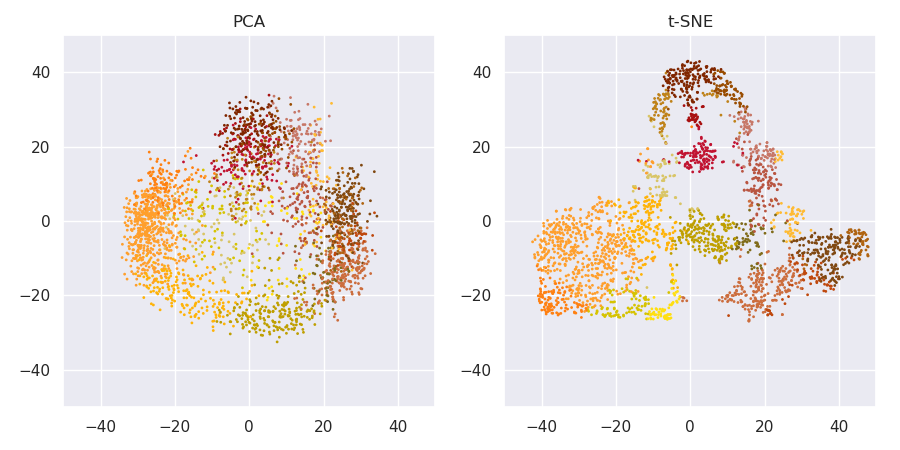

In [42]:
# Plot PCA and t-SNE of SST only

sns.set()
plt.figure(figsize=(9,4.5))
plt.subplot(121, aspect='equal')
plt.scatter(X[:,0], X[:,1], s=1, 
            color = tasic2018['clusterColors'][tasic2018['clusters'][sst]], 
            rasterized = True)
plt.xlim([-50,50])
plt.ylim([-50,50])
plt.title('PCA')
plt.subplot(122, aspect='equal')
plt.scatter(Zsstonly[:,0], Zsstonly[:,1], s=1, 
            color = tasic2018['clusterColors'][tasic2018['clusters'][sst]], 
            rasterized = True)
plt.xlim([-50,50])
plt.ylim([-50,50])
plt.title('t-SNE')
plt.tight_layout()

In [50]:
# Map to t-SNE and do cluster assignment

pos, pos_boot = rnaseqTools.map_to_tsne(tasic2018['counts'][sst,:][:,sstgenes],
                              tasic2018['genes'][sstgenes],
                              l4['counts'], l4['genes'], Zsstonly, bootstrap=True, seed=42, knn=10)

ass, ass_boot = rnaseqTools.map_to_clusters(tasic2018['counts'][:,:][:,sstgenes],
                              tasic2018['genes'][sstgenes],
                              l4['counts'], l4['genes'], 
                              tasic2018['clusters'], bootstrap=True, seed=42)

Using a common set of 472 genes.
Bootstrapping.................................................................................................... done
Using a common set of 472 genes.
.................................................................................................... done


In [51]:
assgroup = tasic2018['clusterNames'][ass.astype(int)]
assgroup[np.isin(assgroup, ['Sst Calb2 Pdlim5'])] = 'Calb2'
assgroup[np.isin(assgroup, ['Sst Hpse Cbln4'])] = 'Hpse'
assgroup[np.isin(assgroup, ['Sst Mme Fam114a1', 'Sst Calb2 Necab1', 'Sst Tac1 Htr1d', 'Sst Tac1 Tacr3'])] = 'Tac1'
assgroup[~np.isin(assgroup, ['Calb2', 'Hpse', 'Tac1'])] = 'L5 types'

In [46]:
# Type assignment statistics

selection = good & ~pvalb & ~excit & (l4['layers']==4) #& ~np.isnan(l4.ephys[:,0])
a,b=np.unique(ass[selection], return_counts=True)
print(tasic2018['clusterNames'][a.astype(int)], '\n', b, np.sum(b))

selection = good & ~pvalb & ~excit & (l4['layers']==4) & (l4['regions']=='S1')
a,b=np.unique(ass[selection], return_counts=True)
print(tasic2018['clusterNames'][a.astype(int)], '\n', b, np.sum(b))

selection = good & ~pvalb & ~excit & (l4['layers']==4) & (l4['regions']=='V1')
a,b=np.unique(ass[selection], return_counts=True)
print(tasic2018['clusterNames'][a.astype(int)], '\n', b, np.sum(b))

selection = good & ~pvalb & ~excit & (l4['layers']==5) & (l4['regions']=='S1')
a,b=np.unique(ass[selection], return_counts=True)
print(tasic2018['clusterNames'][a.astype(int)], '\n', b, np.sum(b))

selection = good & ~pvalb & ~excit & (l4['layers']==5) & (l4['regions']=='V1')
a,b=np.unique(ass[selection], return_counts=True)
print(tasic2018['clusterNames'][a.astype(int)], '\n', b, np.sum(b))

scipy.stats.fisher_exact([[2, 27], [21, 12]])[1]

['Sst Mme Fam114a1' 'Sst Tac1 Htr1d' 'Sst Tac1 Tacr3' 'Sst Calb2 Necab1'
 'Sst Calb2 Pdlim5' 'Sst Hpse Sema3c' 'Sst Hpse Cbln4'] 
 [ 4  5  2  3 23  1 39] 77
['Sst Mme Fam114a1' 'Sst Tac1 Htr1d' 'Sst Calb2 Necab1' 'Sst Calb2 Pdlim5'
 'Sst Hpse Cbln4'] 
 [ 3  2  1  2 27] 35
['Sst Mme Fam114a1' 'Sst Tac1 Htr1d' 'Sst Tac1 Tacr3' 'Sst Calb2 Necab1'
 'Sst Calb2 Pdlim5' 'Sst Hpse Sema3c' 'Sst Hpse Cbln4'] 
 [ 1  3  2  2 21  1 12] 42
['Sst Calb2 Pdlim5' 'Sst Nr2f2 Necab1' 'Sst Hpse Sema3c' 'Sst Hpse Cbln4'
 'Sst Crhr2 Efemp1' 'Sst Crh 4930553C11Rik ' 'Sst Tac2 Tacstd2'
 'Sst Rxfp1 Eya1' 'Sst Rxfp1 Prdm8'] 
 [1 1 1 2 3 3 1 1 3] 16
['Sst Tac1 Htr1d' 'Sst Calb2 Pdlim5' 'Sst Hpse Sema3c' 'Sst Hpse Cbln4'
 'Sst Crhr2 Efemp1' 'Sst Crh 4930553C11Rik ' 'Sst Tac2 Tacstd2'
 'Sst Rxfp1 Eya1' 'Sst Rxfp1 Prdm8'] 
 [1 3 1 1 2 2 1 2 4] 17


3.4639199841591957e-06

In [153]:
# # Export class assignment for Yves

# selection = good & ~pvalb & ~excit

# groups = {'L5 clusters': ['Tac2', 'Rxfp1', 'Crh', 'Crhr2', 'Nr2f2'],
#           'Calb2':       ['Calb2'],
#           'Hpse':        ['Hpse'],
#           'Tac1/Mme':    ['Tac1', 'Mme']}

# assgroup = np.zeros(ass.shape[0]).astype(str)
# asscertain = np.zeros(ass.shape[0]).astype(str)
# for i in range(ass.shape[0]):
#     if ~selection[i]:
#         assgroup[i] = 'bad quality'
#         asscertain[i] = '.'
#     else:
#         for g in groups:
#             if tasic2018.clusterNames[ass[i].astype(int)].split()[1] in groups[g]:
#                 assgroup[i] = g

#         g = assgroup[i]
#         cl = np.array([c.split()[1] in groups[g] for c in tasic2018.clusterNames])
#         if np.sum(ass_boot[i,cl]) < .95:
#             asscertain[i] = '?'
#         else:
#             asscertain[i] = '.'
        
# a,b=np.unique(assgroup, return_counts=True)
# print(dict(zip(list(a),list(b))))

# cellnames = [''.join(c.split('_')[:3]) for c in l4.cells]
# values = np.concatenate((assgroup[:,np.newaxis], asscertain[:,np.newaxis]), axis=1)

# df = pd.DataFrame(np.concatenate((assgroup[:,np.newaxis], asscertain[:,np.newaxis]), axis=1), index=cellnames)
# df.to_csv('transcriptomic_labels.csv', header=False, sep='\t')

In [154]:
# # Export class assignent for Allen

# selection = good & ~pvalb & ~excit

# assallen = tasic2018.clusterNames[ass.astype(int)]
# assallen[~selection] = 'bad quality'

# asscertainallen = np.zeros(ass.shape[0])
# for i in range(ass.shape[0]):
#     asscertainallen[i] = ass_boot[i, int(ass[i])]
# asscertainallen[~selection] = '0'

# ass_boot_allen = ass_boot.copy()
# ass_boot_allen[~selection,:] = 0

# df = pd.DataFrame(np.concatenate((l4.regions[:,np.newaxis], 
#                                   l4.layers[:,np.newaxis].astype(int),
#                                   assallen[:,np.newaxis],
#                                   asscertainallen[:,np.newaxis],
#                                   ~np.isnan(l4.ephys[:,0])[:,np.newaxis],
#                                   ass_boot_allen[:,sstcl]), axis=1), 
#                   index=l4.cells, columns=['area', 'layer', 'cluster', 'confidence', 'ephys']+list(tasic2018.clusterNames[sstcl]))
# df.index.name='cell'
# df = df.sort_values(['area', 'layer'])
# df.to_csv('patchseq-L4paper-mapped-to-tasic-sst.csv', header=True, sep='\t')
# df

In [163]:
# selection = good & ~pvalb & ~excit & ~np.isnan(l4.ephys[:,0]) 

# sns.set()
# plt.figure(figsize=(5,5))
# rnaseqTools.scatterPlot(Zsstonly, tasic2018, alpha=1, showlabels=True,
#                         clusterlabelsplit=True, labels_dy=.2, showmeans=False, size=None)

# ii = (l4.regions[selection]=='V1') & (l4.layers[selection]==4) 
# a = plt.scatter(pos[selection,:][ii,0], pos[selection,:][ii,1], s=40, 
#                 color='orange', edgecolors='k', linewidth=.5)
# ii = (l4.regions[selection]=='V1') & (l4.layers[selection]==5) 
# b = plt.scatter(pos[selection,:][ii,0], pos[selection,:][ii,1], s=40, 
#                 color='orange', edgecolors='k', linewidth=.5, marker='s')

# ii = (l4.regions[selection]=='S1') & (l4.layers[selection]==4) 
# c = plt.scatter(pos[selection,:][ii,0], pos[selection,:][ii,1], s=40, 
#                 color='#ff0000', edgecolors='k', linewidth=.5)
# ii = (l4.regions[selection]=='S1') & (l4.layers[selection]==5) 
# d = plt.scatter(pos[selection,:][ii,0], pos[selection,:][ii,1], s=40, 
#                 color='#ff0000', edgecolors='k', linewidth=.5, marker='s')

# plt.legend([a,b,c,d], ['V1 L4','V1 L5','S1 L4', 'S1 L5'], frameon=False, fontsize=10);

# plt.tight_layout()

In [165]:
# sns.set()
# rnaseqTools.scatterPlot(Zsstonly, tasic2018, showlabels=False, size=5, 
#                         hideticklabels=True, alpha=1, rasterized=False,
#                         clusterlabelsplit=True, labels_dy=.2, showmeans=False)

# selection = good & ~pvalb & ~excit & ~np.isnan(l4.ephys[:,0]) 
# plt.scatter(pos[selection,:][ii,0], pos[selection,:][ii,1], s=40, 
#                 color='k', edgecolors='k', linewidth=.5)

# from scipy.spatial import ConvexHull
# count=0
# nonprecise = np.zeros_like(good)
# for cell in np.where(selection)[0]:
#     points = np.squeeze(pos_boot[cell,:,:]).T
#     distances = np.sum((points - pos[cell,:])**2, axis=1)
#     ind = np.argsort(distances)[:-5]
    
#     if distances[ind[-1]] > 20**2:
#         count = count + 1
#         nonprecise[cell] = True
#         plt.plot(pos[cell,0], pos[cell,1], 'k.')
        
#         points = points[ind,:]
#         hull = ConvexHull(points)
#         for simplex in hull.simplices:
#             plt.plot(points[simplex, 0], points[simplex, 1], color='#ff0000', linewidth=1)
#     else: 
#         points = points[ind,:]
#         hull = ConvexHull(points)
#         for simplex in hull.simplices:
#             plt.plot(points[simplex, 0], points[simplex, 1], color='k', linewidth=1)
        
# # print('Not precisely mapped:', count)
# # print('')
# # print('\n'.join(l4.cells[nonprecise]))

## Reduced-rank regression

102
Chosen offset: 7.08


/home/localadmin/Dropbox (Machens Lab)/Link to rnaseq/layer4/patch-seq/rnaseqTools.py:46: RuntimeWarning: divide by zero encountered in log2
  meanExpr[detected] = np.nanmean(np.where(data[:,detected]>threshold, np.log2(data[:,detected]), np.nan), axis=0)


<IPython.core.display.Javascript object>


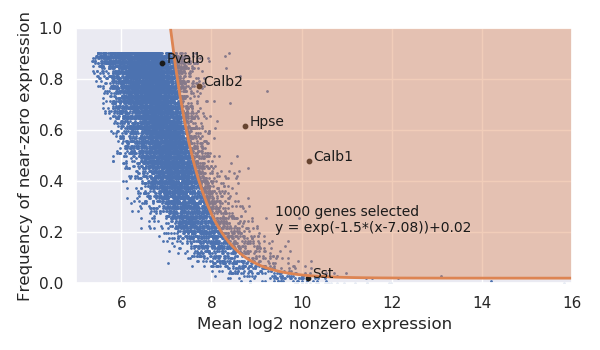

In [80]:
selection = good & ~pvalb & ~excit & ~np.isnan(np.sum(l4['ephys'],axis=1))
print(np.sum(selection))

sns.set()
genesForRRR = rnaseqTools.geneSelection(l4['counts'][selection,:], n=1000, threshold=32, decay=1.5, 
                                     markers=['Sst', 'Pvalb', 'Hpse', 'Calb2', 'Calb1', 'Mme', 'Tac1', 'Tac2'],
                                     genes=l4['genes'])

In [10]:
selection = good & ~pvalb & ~excit & ~np.isnan(np.sum(l4['ephys'],axis=1))

X = l4['counts'][selection,:] / np.sum(l4['counts'][selection,:], axis=1, keepdims=True) * 1e+6
X = np.log2(X + 1)
X = X[:, genesForRRR]
X = X - np.mean(X, axis=0)
X = X / np.std(X, axis=0)

Y = l4['ephys'][selection,:]
Y = Y - np.mean(Y, axis=0)
Y = Y / np.std(Y, axis=0)

print('Shape of X:', X.shape, '\nShape of Y:', Y.shape)

Shape of X: (102, 1000) 
Shape of Y: (102, 13)


1.......... 2.......... 3.......... 4.......... 5.......... 6.......... 7.......... 8.......... 9.......... 10.......... Time: 0.0h 10m  2s


<IPython.core.display.Javascript object>


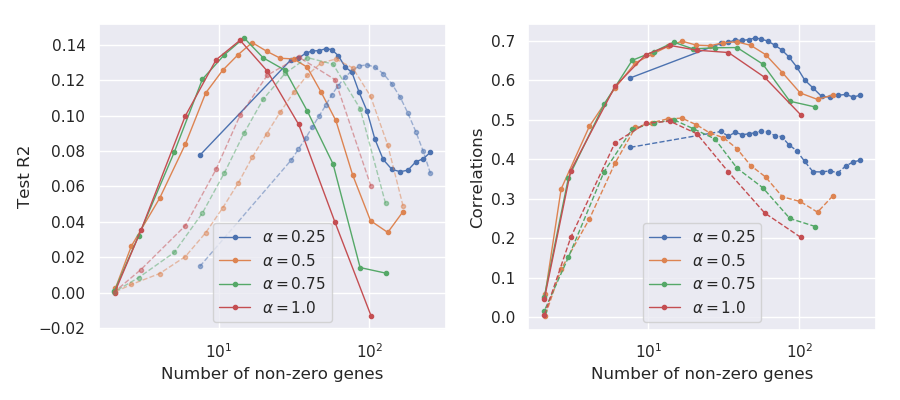

In [11]:
lambdas = np.concatenate([np.arange(.1,2,.1), np.arange(2,10)])
alphas = np.array([.25, .5, .75, 1])

r2, r2_relaxed, nonzero, corrs, corrs_relaxed = sparseRRR.elastic_rrr_cv(
    X, Y, rank=2, reps=10, folds=10, alphas=alphas, lambdas=lambdas)

sns.set()
sparseRRR.plot_cv_results(r2, r2_relaxed, nonzero, corrs, corrs_relaxed, alphas)

In [40]:
print('Best lambda value for alpha=.5: ', lambdas[np.argmax(np.mean(r2_relaxed[:,:,:,1], axis=(0,1)))])

print('Top R2:  {:.2f}'.format(np.squeeze(np.mean(r2_relaxed, axis=(0,1))[lambdas==1][:,alphas==.5])))
print('Top rho1: {:.2f}'.format(np.squeeze(np.mean(corrs_relaxed, axis=(0,1))[lambdas==1][:,alphas==.5][:,:,0])))
print('Top rho2: {:.2f}'.format(np.squeeze(np.mean(corrs_relaxed, axis=(0,1))[lambdas==1][:,alphas==.5][:,:,1])))

w,v = sparseRRR.relaxed_elastic_rrr(X, Y, rank=2, lambdau=1, alpha=.5)

print('')
print(l4['genes'][genesForRRR][np.where(w[:,0]!=0)[0]])
print(np.sum(w[:,0]!=0))

Best lambda value for alpha=.5:  1.1
Top R2:  0.14
Top rho1: 0.69
Top rho2: 0.49

['Pcp4l1' 'Ptprt' 'Pdyn' 'Fstl5' 'Kcnab1' 'Col11a1' 'Grin3a' 'Calb1'
 'Gabrd' 'Reln' 'Hpse' 'Nell1' 'Htra1' 'Ntm' 'AW551984' 'Grik2' 'Gabra1'
 'Akr1c18' 'Pcsk5' 'Ifit2']
20


# Main text mega patch-seq figure

<IPython.core.display.Javascript object>


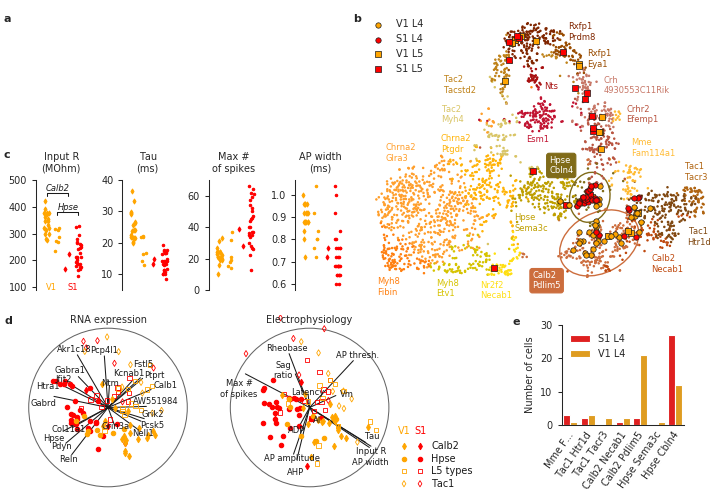

In [118]:
sns_styleset()
plt.figure(figsize=(7.2, 5))

########################################
# Subplot that Federico will fill in

examples = plt.axes([0, .7, .5, .3])
plt.text(.01, .85,  'a', transform = examples.transAxes, fontsize=8, fontweight='bold');
plt.xticks([])
plt.yticks([])
sns.despine(ax=examples, left=True, bottom=True)


########################################
# tSNE subplot

tsne = plt.axes([.5, .4, .5, .6], aspect='equal')

# plt.gca().set_aspect('equal', adjustable='box')
plt.scatter(Zsstonly[:,0], Zsstonly[:,1], s=1, 
            color = tasic2018['clusterColors'][tasic2018['clusters'][sst]])

offsets = {'Sst Mme Fam114a1':[1,5], 'Sst Tac1 Htr1d':[6,-10], 'Sst Tac1 Tacr3':[-3,5],
       'Sst Calb2 Necab1':[1,-10], 'Sst Calb2 Pdlim5':[-18,-12], 'Sst Nr2f2 Necab1':[-7,-8],
       'Sst Myh8 Etv1 ':[-9,-9], 'Sst Myh8 Fibin':[-5,-10], 'Sst Chrna2 Glra3':[-12,13],
       'Sst Chrna2 Ptgdr':[-13,10], 'Sst Tac2 Myh4':[-17,4], 'Sst Hpse Sema3c':[-9,-10],
       'Sst Hpse Cbln4':[-11,7], 'Sst Crhr2 Efemp1':[8,6], 'Sst Crh 4930553C11Rik ':[4,4],
       'Sst Esm1':[-4,-7], 'Sst Tac2 Tacstd2':[-17,-7], 'Sst Rxfp1 Eya1':[6,-4],
       'Sst Rxfp1 Prdm8':[11,0], 'Sst Nts':[3,-3]}
specials = ['Sst Calb2 Pdlim5', 'Sst Hpse Cbln4']

for ssttype in np.where(sstcl)[0]:
    mu = np.median(Zsstonly[tasic2018['clusters'][sst]==ssttype, :2], axis=0)
    mu += offsets[tasic2018['clusterNames'][ssttype]]
    label = '\n'.join(tasic2018['clusterNames'][ssttype].split()[1:])
    col = tasic2018['clusterColors'][ssttype]
    if tasic2018['clusterNames'][ssttype] in specials:
        plt.text(mu[0], mu[1], label, fontsize=6, color='w',
                 bbox=dict(boxstyle="round", ec=col, fc=col))
    else:
        plt.text(mu[0], mu[1], label, fontsize=6, color=col)
        
for ssttype in specials:
    points = Zsstonly[tasic2018['clusterNames'][tasic2018['clusters'][sst]]==ssttype, :]
    mu = points.mean(axis=0)
    Sigma = np.cov(points, rowvar=False)
    val, vec = np.linalg.eigh(Sigma)
    mult = scipy.stats.chi2.ppf(.8, 2)
    width, height = 2 * np.sqrt(val[:, None] * mult)
    theta = np.degrees(np.arctan2(*vec[::-1, 0]))
    ellip = matplotlib.patches.Ellipse(xy=mu, width=width, height=height, angle=theta, 
                                   edgecolor=tasic2018['clusterColors'][tasic2018['clusterNames']==ssttype][0],
                                   linewidth=1, facecolor='none', zorder=0)
    plt.gca().add_artist(ellip)
        
plt.xticks([])
plt.yticks([])
sns.despine(ax=tsne, left=True, bottom=True)

selection = good & ~pvalb & ~excit
s = 15
ii = (l4['regions'][selection]=='V1') & (l4['layers'][selection]==4) 
a = plt.scatter(pos[selection,:][ii,0], pos[selection,:][ii,1], s=s, 
                color='orange', edgecolors='k', linewidth=.5, zorder=2)
ii = (l4['regions'][selection]=='S1') & (l4['layers'][selection]==4) 
b = plt.scatter(pos[selection,:][ii,0], pos[selection,:][ii,1], s=s, 
                color='red', edgecolors='k', linewidth=.5, zorder=2)
ii = (l4['regions'][selection]=='V1') & (l4['layers'][selection]==5) 
c = plt.scatter(pos[selection,:][ii,0], pos[selection,:][ii,1], s=s, marker='s',
                color='orange', edgecolors='k', linewidth=.5, zorder=1)
ii = (l4['regions'][selection]=='S1') & (l4['layers'][selection]==5) 
d = plt.scatter(pos[selection,:][ii,0], pos[selection,:][ii,1], s=s,marker='s',
                color='red', edgecolors='k', linewidth=.5, zorder=1)

plt.legend([a,b,c,d], ['V1 L4', 'S1 L4', 'V1 L5', 'S1 L5'], frameon=False, loc='upper left')
plt.text(-0.02, .96,  'b', transform = tsne.transAxes, fontsize=8, fontweight='bold');

In [119]:
selection = good & ~pvalb & ~excit & (l4['layers']==4)

########################################
# barplot subplot

bar = plt.axes([.78, 0.15, .17, .2])

sstids     = np.unique(ass[selection])
sstnames   = tasic2018['clusterNames'][sstids.astype(int)]
sstnames   = [s.split()[1] + ' ' + (s.split()[2] if len(s.split()[2])<=6 else s.split()[2][0]+'...')
              for s in sstnames]
sstcounts  = np.zeros((sstids.size,2))
for num,i in enumerate(sstids):
    ind = (l4['regions'][selection]=='S1') & (l4['layers'][selection]==4)
    sstcounts[num,0] = np.sum(ass[selection][ind] == i)
    ind = (l4['regions'][selection]=='V1') & (l4['layers'][selection]==4)
    sstcounts[num,1] = np.sum(ass[selection][ind] == i)    

mydata = pd.DataFrame(sstcounts, index=sstnames, columns=['S1 L4','V1 L4'])
mydata = mydata.reset_index().melt(id_vars=['index'], var_name='Area')

sns.barplot(data=mydata, x='index', y='value', hue='Area', 
            palette={'V1 L4':[1,.65,0], 'S1 L4':[1,0,0]})
# plt.legend(['V1 L4', 'S1 L4'], frameon=False)
plt.gca().legend().set_title('')
plt.gca().legend().get_frame().set_edgecolor('none')
plt.gca().xaxis.set_tick_params(length=0)
plt.xticks(np.arange(7)+.3, rotation=55, ha='right')

plt.ylabel('Number of cells')
plt.xlabel('')
plt.yticks([0,10,20,30])
sns.despine(ax=bar)
plt.text(-.4, 1,  'e', transform = bar.transAxes, fontsize=8, fontweight='bold');

In [120]:
cohends = []
for f in range(l4['ephys'].shape[1]):
    a = good & ~pvalb & ~excit & ~np.isnan(l4['ephys'][:,0]) & (l4['regions']=='V1') & (l4['layers']==4)
    b = good & ~pvalb & ~excit & ~np.isnan(l4['ephys'][:,0]) & (l4['regions']=='S1') & (l4['layers']==4)
    x = l4['ephys'][a,f]
    y = l4['ephys'][b,f]
    d = np.abs(np.mean(x) - np.mean(y)) / np.std(np.concatenate((x-x.mean(), y-y.mean())))
    cohends.append(d)
cohends = np.array(cohends)

ind = np.argsort(cohends)[::-1]
print('\n'.join([str(cohends[i])[:5]+'\t'+l4['ephysNames'][i] for i in ind]))
featuresToShow = ind[:4]

########################################
# ephys features subplots

ephys = []
ephys.append(plt.axes([.05,       .42, .07, .22]))
ephys.append(plt.axes([.05+.12*1, .42, .07, .22]))
ephys.append(plt.axes([.05+.12*2, .42, .07, .22]))
ephys.append(plt.axes([.05+.12*3, .42, .07, .22]))

titles = ['Input R\n(MOhm)', 'Tau\n(ms)', 'Max #\nof spikes', 'AP width\n(ms)']
s=3
jitter=0.2
np.random.seed(42)

selection = good & ~pvalb & ~excit & ~np.isnan(l4['ephys'][:,0]) & (l4['regions']=='V1') & \
            (l4['layers']==4) & (tasic2018['clusterNames'][ass.astype(int)]=='Sst Calb2 Pdlim5')
for i,f in enumerate(featuresToShow):
    plt.sca(ephys[i])
    plt.scatter(np.random.uniform(size=np.sum(selection))*jitter, l4['ephys'][selection,f], 
                s=s*2, color='orange', marker='d')
    plt.xticks([])
    plt.title(titles[i])
    plt.xlim([-0.3,1.6])
    
selection = good & ~pvalb & ~excit & ~np.isnan(l4['ephys'][:,0]) & (l4['regions']=='V1') & \
            (l4['layers']==4) & (tasic2018['clusterNames'][ass.astype(int)]=='Sst Hpse Cbln4')
for i,f in enumerate(featuresToShow):
    plt.sca(ephys[i])
    plt.scatter(np.random.uniform(size=np.sum(selection))*jitter+.4, l4['ephys'][selection,f], 
                #facecolors='none', edgecolors='orange', s=s, linewidth=.8)
                s=s, color='orange')
    
selection = good & ~pvalb & ~excit & ~np.isnan(l4['ephys'][:,0]) & (l4['regions']=='S1') & \
            (l4['layers']==4) & (tasic2018['clusterNames'][ass.astype(int)]=='Sst Calb2 Pdlim5')
for i,f in enumerate(featuresToShow):
    plt.sca(ephys[i])
    plt.scatter(np.random.uniform(size=np.sum(selection))*jitter+.8, l4['ephys'][selection,f], 
                s=s*2, color='red', marker='d')
    
selection = good & ~pvalb & ~excit & ~np.isnan(l4['ephys'][:,0]) & (l4['regions']=='S1') & \
            (l4['layers']==4) & (tasic2018['clusterNames'][ass.astype(int)]=='Sst Hpse Cbln4')
for i,f in enumerate(featuresToShow):
    plt.sca(ephys[i])
    plt.scatter(np.random.uniform(size=np.sum(selection))*jitter+1.2, l4['ephys'][selection,f],
               #facecolors='none', edgecolors='red', s=s, linewidth=.8)
                s=s, color='red')
#     sns.swarmplot(x=np.zeros(np.sum(selection))+1.2+jitter/2, y=l4.ephys[selection,f], color='red', size=2)

plt.sca(ephys[0])
plt.ylim([90,500])
plt.plot([.5*jitter,.8+.5*jitter], [450,450], linewidth=.75, color='k')
plt.plot([.5*jitter,.5*jitter],   [440,450], linewidth=.75, color='k')
plt.plot([.8+.5*jitter,.8+.5*jitter], [440,450], linewidth=.75, color='k')
plt.text(.5*jitter+.4, 460, 'Calb2', color='k', fontsize=6, style='italic', ha='center')
plt.plot([.5*jitter+.4,.8+.5*jitter+.4], [380,380], linewidth=.75, color='k')
plt.plot([.5*jitter+.4,.5*jitter+.4],   [370,380], linewidth=.75, color='k')
plt.plot([.8+.5*jitter+.4,.8+.5*jitter+.4], [370,380], linewidth=.75, color='k')
plt.text(.5*jitter+.4+.4, 390, 'Hpse', color='k', fontsize=6, style='italic', ha='center')
plt.text(jitter/2+.2,    90, 'V1', color='orange', fontsize=6, ha='center')
plt.text(jitter/2+.2+.8, 90, 'S1', color='red', fontsize=6, ha='center')
plt.text(-.65, 1.2,  'c', transform = ephys[0].transAxes, fontsize=8, fontweight='bold')

plt.sca(ephys[1])
plt.ylim([5,40])
plt.sca(ephys[2])
plt.ylim([0,70])
# plt.sca(ephys[3])
# plt.ylim([.5, 1.3])

for e in ephys:
    sns.despine(ax=e, bottom=True)#, trim=True)

2.095	Input R (MOhm)
1.981	Tau (ms)
1.732	Max number of spikes
1.440	AP width (ms)
0.700	Rheobase (pA)
0.449	Sag ratio
0.431	AP threshold (mV)
0.166	AI
0.161	Latency (ms)
0.143	Vm (mV)
0.044	AHP (mV)
0.021	AP amplitude (mV)
0.002	ADP (mV)


In [121]:
selection = good & ~pvalb & ~excit & ~np.isnan(np.sum(l4['ephys'],axis=1))

X = l4['counts'][selection,:] / np.sum(l4['counts'][selection,:], axis=1, keepdims=True) * 1e+6
X = np.log2(X + 1)
X = X[:, genesForRRR]
X = X - np.mean(X, axis=0)
X = X / np.std(X, axis=0)

Y = l4['ephys'][selection,:]
Y = Y - np.mean(Y, axis=0)
Y = Y / np.std(Y, axis=0)

print('Shape of X:', X.shape, '\nShape of Y:', Y.shape)

w,v = sparseRRR.relaxed_elastic_rrr(X, Y, rank=2, lambdau=1, alpha=.5)
print('Number of selected genes: {}'.format(np.sum(w[:,0]!=0)))

Zx = X @ w[:,:2]
Zy = Y @ v[:,:2]
Zx = Zx / np.std(Zx, axis=0)
Zy = Zy / np.std(Zy, axis=0)

markerFaceColors = {'Calb2': None, 'Hpse': None, 'Tac1': 'none', 'L5 types': 'none'}
markerLineWidths = {'Calb2': None, 'Hpse': None, 'Tac1': .6, 'L5 types': .6}
cellTypeMarkers = {'Calb2':'d', 'Hpse':None, 'Tac1':'d', 'L5 types': 's'}
zorders = {'Calb2':4, 'Hpse':3, 'Tac1':2, 'L5 types': 1}

xylim = 3.5
scaleFactor = 3
s = 10

rrr1 = plt.axes([0, 0, .3, .37], aspect='equal')
plt.text(-0.06, .95,  'd', transform = rrr1.transAxes, fontsize=8, fontweight='bold');

for u in np.unique(assgroup[selection]):
    plt.scatter(Zx[(assgroup[selection]==u)&(l4['regions'][selection]=='V1'),0], 
                Zx[(assgroup[selection]==u)&(l4['regions'][selection]=='V1'),1], 
                color='orange', label='V1 ' + u, s=s, zorder=zorders[u]+.1, marker=cellTypeMarkers[u],
                facecolor=markerFaceColors[u], linewidth=markerLineWidths[u])
    plt.scatter(Zx[(assgroup[selection]==u)&(l4['regions'][selection]=='S1'),0], 
                Zx[(assgroup[selection]==u)&(l4['regions'][selection]=='S1'),1], 
                color='red', label='S1 ' + u, marker=cellTypeMarkers[u], s=s, zorder=zorders[u],
                facecolor=markerFaceColors[u], linewidth=markerLineWidths[u])
plt.xlim([-xylim,xylim])
plt.ylim([-xylim,xylim])
plt.xticks([])
plt.yticks([])
sns.despine(ax=rrr1, left=True, bottom=True)
plt.text(0,3.2,'RNA expression', fontsize=7, ha='center')

offsets = {'Gabrd':[-.2,-.3], 'Htra1':[-.2,-.2], 'Hpse': [-.2,-.2], 'Pcsk5': [.3,-.1],
           'Grik2': [.2,.2], 'AW551984': [.2,.2], 'Calb1': [.4,.1], 'Fstl5': [0,.4],
           'Kcnab1': [-.2,.2], 'Ptprt': [.3,0], 'Gabra1': [-.2,.1]}
L = np.corrcoef(np.concatenate((Zx[:,:2], X), axis=1), rowvar=False)[2:,:2]
# for i in np.where((w[:,0]!=0) & (np.sqrt(np.sum(L**2,axis=1))>.5))[0]:
for i in np.where(w[:,0]!=0)[0]:
    plt.plot([0, scaleFactor*L[i,0]], [0, scaleFactor*L[i,1]], linewidth=.75, color='k', zorder=-1)
    label = l4['genes'][genesForRRR][i]
    if label in offsets:
        dx,dy = offsets[label]
    else:
        dx,dy = 0,0
    plt.text(scaleFactor*L[i,0]*1.1+dx, scaleFactor*L[i,1]*1.1+dy, label,
                     ha='center', va='center', color='k', fontsize=6, zorder=10)    
circ = plt.Circle((0,0), radius=scaleFactor, color=[.4, .4, .4], fill=False, linewidth=.75, zorder=-1)
plt.gca().add_patch(circ)


rrr2 = plt.axes([.28, 0, .3, .37], aspect='equal')
for u in np.unique(assgroup[selection]):
    plt.scatter(Zy[(assgroup[selection]==u)&(l4['regions'][selection]=='V1'),0], 
                Zy[(assgroup[selection]==u)&(l4['regions'][selection]=='V1'),1], 
                color='orange', label='V1 ' + u, s=s, zorder=zorders[u]+.1, marker=cellTypeMarkers[u],
                facecolor=markerFaceColors[u], linewidth=markerLineWidths[u])
    plt.scatter(Zy[(assgroup[selection]==u)&(l4['regions'][selection]=='S1'),0], 
                Zy[(assgroup[selection]==u)&(l4['regions'][selection]=='S1'),1], 
                color='red', label='S1 ' + u, marker=cellTypeMarkers[u], s=s, zorder=zorders[u],
                facecolor=markerFaceColors[u], linewidth=markerLineWidths[u])
plt.xlim([-xylim,xylim])
plt.ylim([-xylim,xylim])
plt.xticks([])
plt.yticks([])
sns.despine(ax=rrr2, left=True, bottom=True)
plt.text(0,3.2,'Electrophysiology', fontsize=7, ha='center')

offsets = {'Max number of spikes': [0,-.7], 'Sag ratio': [-.4, 0], 'Vm': [.3,0], 'AHP': [0,-.3],
           'Tau': [-.2,.5], 'AP width': [-.2,-.4], 'Input R': [0,-.2]}
# 'Tau':[-.2,-.1], 'AHP':[0,-.2], 'AP threshold':[0,0], 'Vm': [.2,0],
#           'Sag ratio': [.3,0], 'Input R': [.2,-.3], 'Max number of spikes': [.4,-.2],
#           'AP amplitude': [0,-.2]}
renames = {'Max number of spikes': 'Max #\nof spikes', 'AP threshold': 'AP thresh.',
           'Sag ratio': 'Sag\nratio'}
L = np.corrcoef(np.concatenate((Zy[:,:2], Y), axis=1), rowvar=False)[2:,:2]
for i in range(Y.shape[1]):
    plt.plot([0, scaleFactor*L[i,0]], [0, scaleFactor*L[i,1]], linewidth=.75, color='k', zorder=-1)
    label = l4['ephysNames'][i].split(' (')[0]
    if label in offsets:
        dx,dy = offsets[label]
    else:
        dx,dy = 0,0
    if label in renames:
        label = renames[label]
    plt.text(scaleFactor*L[i,0]*1.1+dx, scaleFactor*L[i,1]*1.1+dy, label,
                     ha='center', va='center', color='k', fontsize=6, zorder=10)
circ = plt.Circle((0,0), radius=scaleFactor, color=[.4, .4, .4], fill=False, linewidth=.75, zorder=-1)
plt.gca().add_patch(circ)

# Custom legend
leg = plt.axes([.55, .02, .1, .1])
for i,u in enumerate(np.unique(assgroup[selection])):
    plt.scatter(0, -i, color='orange', s=s, marker=cellTypeMarkers[u],
                facecolor=markerFaceColors[u], linewidth=markerLineWidths[u])
    plt.scatter(1, -i, color='red', s=s, marker=cellTypeMarkers[u],
                facecolor=markerFaceColors[u], linewidth=markerLineWidths[u])
    plt.text(1.7, -i, u, color='k', fontsize=7, va='center')
plt.text(0, 1, 'V1', fontsize=7, color='orange', ha='center')
plt.text(1, 1, 'S1', fontsize=7, color='red', ha='center')
plt.xticks([])
plt.yticks([])
plt.xlim([-.5,4])
plt.ylim([-3.5,.5])
sns.despine(ax=leg, left=True, bottom=True)

Shape of X: (102, 1000) 
Shape of Y: (102, 13)
Number of selected genes: 20


In [122]:
plt.savefig('../figures/patch-seq.png', dpi=200)
plt.savefig('../figures/patch-seq-600dpi.png', dpi=600)
plt.savefig('../figures/patch-seq.pdf')